## Geospatial Data Analysis with Python

In this exercise, we will work with two new datasets: artisanal mining sites in Eastern Congo and national parks in Congo. We'll follow a step-by-step process to import the necessary packages, read the data using `geopandas.read_file()`, inspect the first 5 rows and the Coordinate Reference System (CRS) of each dataset, and create quick visualizations. <br>
For further analyses , we will convert both datasets to the same CRS, and save both to a new file. To ensure we can do distance-based calculations, we will convert them to a projected CRS: the local UTM zone 35, which is identified by EPSG:32735 (https://epsg.io/32735).

### Artisanal Mining Case Study

#### 1. Import Packages


In [152]:
# Import GeoPandas, Matplotlib and other libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.affinity import affine_transform
from geopandas import GeoDataFrame
from pyproj import Proj, Transformer

#### 2. Spatial Points: Read and Print Mining Sites Dataset Information

In [118]:
# Read the mining site data
mining_sites = gp.read_file('Mines\\ipis_cod_mines.geojson')

# Print the first rows and the CRS information
pd.set_option('display.expand_frame_repr', False)
print(f'Mining Dataset: \n\n {mining_sites}')
print(f'\n The Coordinate Reference System (CRS) for the mining dataset is: {mining_sites.crs}')


Mining Dataset: 

       visit_date                                name  n_workers      mineral                   geometry
0     2013-03-27                           Mayi-Tatu      150.0         Gold   POINT (29.66033 1.01089)
1     2013-03-27                             Mabanga      115.0         Gold   POINT (29.65862 1.00308)
2     2013-03-27                             Molende      130.0         Gold   POINT (29.65629 0.98563)
3     2013-03-27                          Embouchure      135.0         Gold   POINT (29.64494 0.99976)
4     2013-03-27  Apumu-Atandele-Jerusalem-Luka Yayo      270.0         Gold   POINT (29.66000 0.95600)
...          ...                                 ...        ...          ...                        ...
2138  2017-12-14                                  G4      150.0  Cassiterite  POINT (27.57159 -2.31193)
2139  2017-08-28                             Busonga        5.0       Coltan  POINT (29.08323 -1.98792)
2140  2017-08-28                      Buterer

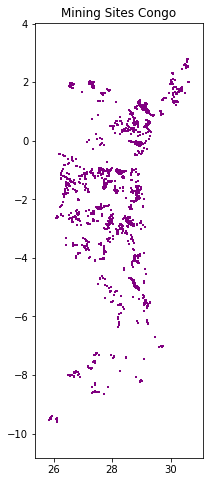

In [140]:
# Make a visualization with custom color and tick marks

# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the data with markers and colors
mining_sites.plot(ax=ax, color='purple', marker='+', markersize=5)

# Add some margins around the plot
ax.margins(0.1)

# Add a title to the plot
ax.set_title("Mining Sites Congo")

# Display the plot
plt.show()


#### 3. Spatial Vector Data: Read and Print National Parks Dataset Information

In [173]:
# Read the national parks site data
national_parks = gp.read_file('wdpamay2017cod-shapefile-polygons.geojson')
# print(national_parks)

# Print column names from the dataframe
column_names = national_parks.columns
num_columns = len(column_names)
num_columns_per_row = 10
num_rows = -(-num_columns // num_columns_per_row)  # Ceiling division

print("Column Names:")
for i in range(num_rows):
    columns_row = column_names[i * num_columns_per_row : (i + 1) * num_columns_per_row]
    print(" - ".join(columns_row))
 
#subset the dataframe
national_parks_subset  = national_parks[['NAME', 'DESIG_ENG', 'DESIG_TYPE', 'GIS_AREA']]
national_parks_subset_sorted = national_parks_subset.sort_values(by='GIS_AREA', ascending=False)


# Print the first rows and the CRS information
print(f'\n National Parks Dataset \n  {national_parks_subset_sorted.head(40)}')
print(f'\n The Coordinate Reference System (CRS) for the national parks dataset is: {national_parks.crs}')

Column Names:
WDPAID - WDPA_PID - PA_DEF - NAME - ORIG_NAME - DESIG - DESIG_ENG - DESIG_TYPE - IUCN_CAT - INT_CRIT
MARINE - REP_M_AREA - GIS_M_AREA - REP_AREA - GIS_AREA - NO_TAKE - NO_TK_AREA - STATUS - STATUS_YR - GOV_TYPE
OWN_TYPE - MANG_AUTH - MANG_PLAN - VERIF - METADATAID - SUB_LOC - PARENT_ISO - ISO3 - geometry

 National Parks Dataset 
                                        NAME                                         DESIG_ENG     DESIG_TYPE      GIS_AREA
43                   Salonga National Park                               World Heritage Site  International  35321.977615
3                                  Salonga                          Integrale Nature Reserve       National  33592.750558
17                               Bili-Uere                                      Not Reported       National  33009.739706
27                                 Sankuru                                    Nature Reserve       National  24937.501330
42                  Okapi Wildlife Reserve

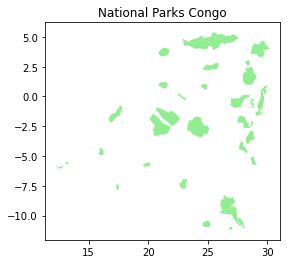

In [190]:
# Make a visualization
national_parks.plot(color='lightgreen')

# Add a title to the plot
plt.title("National Parks Congo")

# Display the plot
plt.show()

#### 4. Apply Spatial Transformations: Integrate Data Sources

In [151]:
# Define the source and target coordinate systems
source_crs = Proj("EPSG:4326")
target_crs = Proj("EPSG:32735")

# Create a coordinate transformer
transformer = Transformer.from_proj(source_crs, target_crs, always_xy=True)

# Process the points dataset 
# Retrieve the point data from the DataFrame
points = mining_sites['geometry']

# Perform coordinate transformation for each point
transformed_points = []
for point in points:
    transformed_point = transformer.transform(point.x, point.y)
    transformed_geometry = Point(transformed_point[0], transformed_point[1])
    transformed_points.append(transformed_geometry)

# Add the transformed geometry to the DataFrame
mining_sites['transformed_geometry'] = transformed_points

# Create a GeoDataFrame with the transformed geometry
mining_sites_utm = gp.GeoDataFrame(mining_sites, geometry='transformed_geometry')

# mining_sites.drop(columns=['geometry'], inplace=True)
# Assign the CRS to the DataFrame
mining_sites_utm.crs = "EPSG:32735"  # Replace with the appropriate CRS for the transformed_geometry column

print(f'Transformed Mining Site Dataset: \n\n {mining_sites_utm}')

# Process the vector dataset
polygons = national_parks['geometry']

# Create an empty list to store the transformed polygons
transformed_polygonsList = []

# Create an empty list to store the object types
object_types = []


# Iterate over each row in the DataFrame
for index, row in national_parks.iterrows():
    # print(f'The index is {index}')
    # Get the geometry string from the 'geometry' column
    geometry = row['geometry']

    # Determine the object type and append it to the list
    # print(type(geometry))
    if isinstance(geometry, Polygon):
        object_types.append('Polygon')
    elif isinstance(geometry, MultiPolygon):
        object_types.append('MultiPolygon')
    else:
        raise ValueError("Invalid geometry type")
    
    # print(object_types)

    x_coordinates = []
    y_coordinates = []
    
    # Get the geometry object from the 'geometry' column and convert it to a string
    geometry_string = str(row['geometry'])

    coordinates_string = geometry_string.split("((")[1].split("))")[0].strip("()")

    #Handle exceptions
    if(index == 39):
        # print("Exception 39")
        # Split the geometry string into individual polygons
        polygon_strings = coordinates_string.split("), (")
        # Remove the trailing ')' from the last element
        last_polygon = polygon_strings[-1].rstrip(")")

        # Update the last element in the list
        polygon_strings[-1] = last_polygon
        # print(polygon_strings)

        # Iterate over each polygon string
        for polygon_string in polygon_strings:
            # Remove the opening and closing brackets
            polygon_string = polygon_string.strip("()")
            polygon_string = polygon_string.strip("(")

            # Split the polygon string into individual coordinates
            coordinates = [coord.split() for coord in polygon_string.split(",")]

            # Extract the x and y coordinates and convert them to floats
            for coord in coordinates:
                # print (coord)
                x, y = map(float, coord)
                transformed_point = transformer.transform(x, y)
                transformed_points.append(transformed_geometry)
                x_coordinates.append(x)
                y_coordinates.append(y)

                # Append the coordinates to the lists
                x_coordinates.append(transformed_point[0])
                y_coordinates.append(transformed_point[1])      

        # Create a Shapely Polygon object from the transformed coordinates
        transformed_coordinates = zip(x_coordinates, y_coordinates)
        transformed_polygons = Polygon(transformed_coordinates)
        # Append the transformed polygon to the list
        transformed_polygonsList.append(transformed_polygons)
        continue

    coordinates = [coord.split() for coord in coordinates_string.split(",")]
    # print(type(coordinates), coordinates)

    # Extract the x and y coordinates and convert them to floats
    for coord in coordinates:
        x, y = map(float, coord)
        transformed_point = transformer.transform(x, y)
        # transformed_geometry = Point(transformed_point[0], transformed_point[1])
        transformed_points.append(transformed_geometry)

        x_coordinates.append(transformed_point[0])
        y_coordinates.append(transformed_point[1])
    
    # Create a Shapely Polygon object from the transformed coordinates
    transformed_coordinates = zip(x_coordinates, y_coordinates)
    transformed_polygons = Polygon(transformed_coordinates)
    
    # Append the transformed polygon to the list
    transformed_polygonsList.append(transformed_polygons)

# national_parks_utm = gp.GeoDataFrame(national_parks.drop(columns=['geometry']), geometry=transformed_polygons)
national_parks['transformed_geometry'] = transformed_polygonsList
# print(national_parks)

national_parks_utm = gp.GeoDataFrame(national_parks, geometry='transformed_geometry')

# Assign the CRS to the DataFrame
national_parks_utm.crs = "EPSG:32735"  # Replace with the appropriate CRS for the transformed_geometry column

#subset the dataframe
national_parks_utm_subset  = national_parks[[ 'geometry', 'transformed_geometry']]



print(f'\n\nTransformed National Parks Dataset: \n\n {national_parks_utm_subset.head()}')





Transformed Mining Site Dataset: 

       visit_date                                name  n_workers      mineral                   geometry             transformed_geometry
0     2013-03-27                           Mayi-Tatu      150.0         Gold   POINT (29.66033 1.01089)  POINT (796089.416 10111855.174)
1     2013-03-27                             Mabanga      115.0         Gold   POINT (29.65862 1.00308)  POINT (795899.664 10110990.840)
2     2013-03-27                             Molende      130.0         Gold   POINT (29.65629 0.98563)  POINT (795641.707 10109059.787)
3     2013-03-27                          Embouchure      135.0         Gold   POINT (29.64494 0.99976)  POINT (794376.309 10110622.250)
4     2013-03-27  Apumu-Atandele-Jerusalem-Luka Yayo      270.0         Gold   POINT (29.66000 0.95600)  POINT (796057.504 10105781.548)
...          ...                                 ...        ...          ...                        ...                              ...
2138 

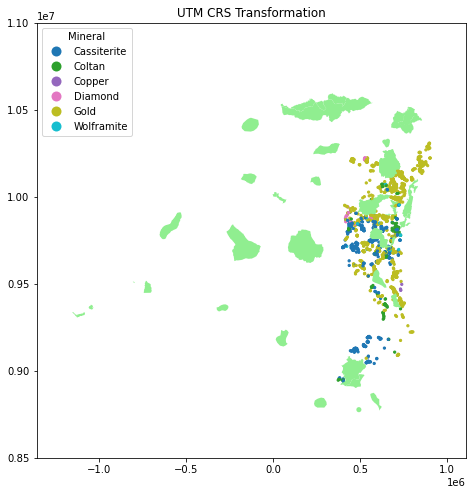

In [189]:
#Visualize the transformations 

# Define the desired x-axis and y-axis ranges
ymin = 8500000  # Replace with the minimum y-coordinate value
ymax = 11000000  # Replace with the maximum y-coordinate value

# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot mining sites with markers and custom color, symbolized by mineral (excluding blue)
mining_sites_utm.plot(ax=ax, column='mineral', markersize=5, legend=True, legend_kwds={'loc': 'upper left', 'title': 'Mineral'})


# Plot national parks with light green color
national_parks_utm.plot(ax=ax, color='lightgreen')

# Set the x-axis and y-axis limits to zoom in on the top-right region
# ax.set_xlim([xmin, xmax])  # Specify the desired x-axis limits
ax.set_ylim([ymin, ymax])  # Specify the desired y-axis limits

# Add some margins around the plot
ax.margins(0.1)

# Add a title to the plot
ax.set_title("UTM CRS Transformation")

# Display the plot
plt.show()


#### 4. Vector Operations in Python

> Which of the mining sites are located within this national park?

Mining Sites within Kahuzi-Biega National Park: 

        visit_date                   name  n_workers      mineral                   geometry            transformed_geometry
661   2013-08-28          Ibozia/Kalumé       80.0  Cassiterite  POINT (27.61002 -2.17897)  POINT (567832.709 9759143.339)
662   2013-08-26                Matamba      150.0  Cassiterite  POINT (27.88421 -2.18295)  POINT (598323.539 9758688.142)
663   2013-08-27          Mutete/Mukina      170.0  Cassiterite  POINT (27.63610 -2.15428)  POINT (570733.437 9761871.114)
664   2013-08-28                 Mutete      100.0  Cassiterite  POINT (27.62843 -2.15114)  POINT (569881.093 9762219.111)
760   2014-02-25              Mazankala      120.0  Cassiterite  POINT (28.01709 -2.50608)  POINT (613075.533 9722956.980)
813   2015-07-28             Kitendebwa       50.0         Gold  POINT (28.73602 -2.07894)  POINT (693078.928 9770107.518)
869   2013-09-28           Sebwa-Lukoma      130.0  Cassiterite  POINT (28.44283 -2.575

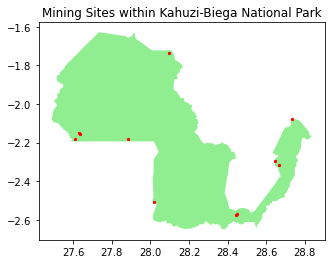

In [191]:
# Extract the single polygon for the Kahuzi-Biega National park
kahuzi = national_parks[national_parks['NAME'] == "Kahuzi-Biega"].geometry.squeeze()

# Take a subset of the mining sites located within Kahuzi
sites_kahuzi = mining_sites[mining_sites.within(kahuzi)]
print(f'Mining Sites within Kahuzi-Biega National Park: \n\n  {sites_kahuzi} \n')


# Create a GeoDataFrame containing only the selected polygon
selected_polygon = gp.GeoDataFrame(geometry=[kahuzi])

# Plot the selected polygon
ax = selected_polygon.plot(color='lightgreen')

# Plot the mining sites within the selected polygon
sites_kahuzi.plot(ax=ax, color='red', marker='o', markersize=5)

# Add a title
plt.title("Mining Sites within Kahuzi-Biega National Park")

# Display the plot
plt.show()